# **1. Imports and Dependencies:**

In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers, models, backend, utils, regularizers, callbacks
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import random
import os
import shutil
import glob
import seaborn as sns

2024-05-18 17:16:50.511717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 17:16:50.511904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 17:16:50.793558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **2. Setting Up Training, Validation and Testing Datasets:**

In [2]:
train_val_dataset_path = "/kaggle/input/car-brand-logos/Car_Brand_Logos/Train"
test_dataset_path = "/kaggle/input/car-brand-logos/Car_Brand_Logos/Test"
train_path = "/kaggle/working/train"
val_path = "/kaggle/working/val"
test_path = "/kaggle/working/test"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

car_brands = os.listdir(train_val_dataset_path)

for brand in car_brands:
    brand_train_path = os.path.join(train_val_dataset_path, brand)
    brand_val_path = os.path.join(val_path, brand)
    os.makedirs(os.path.join(train_path, brand), exist_ok=True)
    os.makedirs(brand_val_path, exist_ok=True)
    images = os.listdir(brand_train_path)
    np.random.shuffle(images)
    train_images = images[:int(0.8*len(images))]  # 80% for training
    val_images = images[int(0.8*len(images)):]    # 20% for validation
    for img in train_images:
        shutil.copy(os.path.join(brand_train_path, img), os.path.join(train_path, brand))
    for img in val_images:
        shutil.copy(os.path.join(brand_train_path, img), os.path.join(brand_val_path, img))

shutil.copytree(test_dataset_path, test_path, dirs_exist_ok=True)

print("Dataset forming is completed!")

Dataset forming is completed!


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224), 
    batch_size=64,  
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


Found 2006 images belonging to 8 classes.
Found 507 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [32]:
# Generators
print(train_generator.class_indices.keys())
print(val_generator.class_indices.keys())
print(test_generator.class_indices.keys())

dict_keys(['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen'])
dict_keys(['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen'])
dict_keys(['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen'])


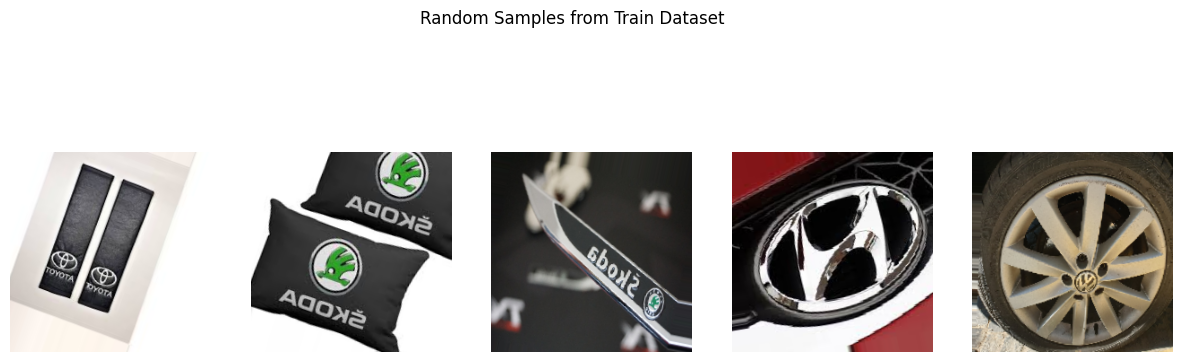

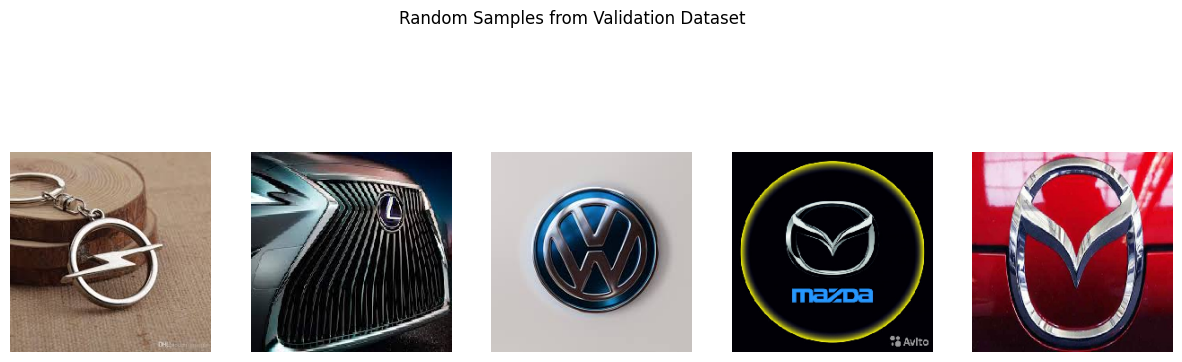

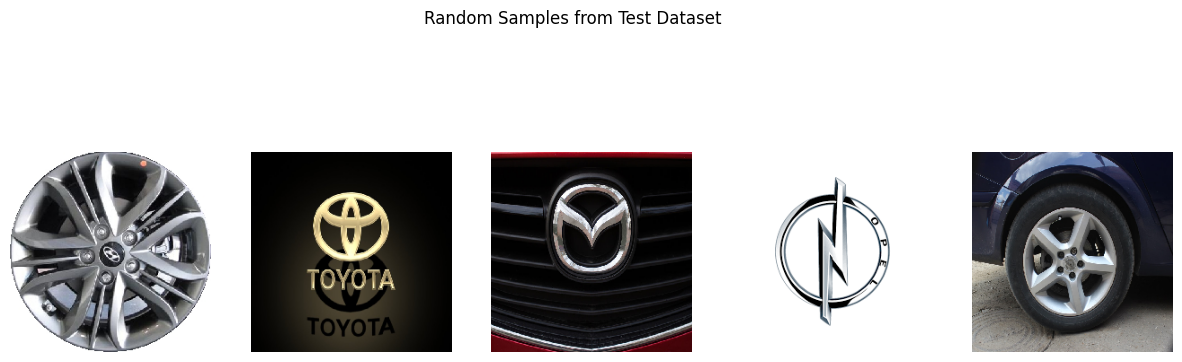

In [33]:
def plot_random_samples(generator, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    for i in range(5):
        plt.subplot(1, 5, i+1)
        batch = next(generator)
        image = batch[0][random.randint(0, len(batch[0])-1)]  # Select a random image from the batch
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    
    
plot_random_samples(train_generator, "Random Samples from Train Dataset")
plot_random_samples(val_generator, "Random Samples from Validation Dataset")
plot_random_samples(test_generator, "Random Samples from Test Dataset")

# **3. Defining the CNN Model:**

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='swish', padding='same', input_shape=(224, 224, 3), kernel_initializer=HeNormal()),
    layers.Conv2D(32, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.Conv2D(64, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.Conv2D(128, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.Conv2D(256, (3, 3), activation='swish', padding='same', kernel_initializer=HeNormal()),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=HeNormal()),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=HeNormal()),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(8, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [5]:
model.compile(optimizer= Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             

 Total params: 27,135,656 (103.51 MB)

 Trainable params: 27,132,648 (103.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

# **4. Training The CNN Model:**

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=200
)

# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716052724.256496     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716052724.284849     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1535 - loss: 5.0138   

W0000 00:00:1716052780.501219     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716052782.656378     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.1532 - loss: 5.0194 - val_accuracy: 0.1272 - val_loss: 5.5849
Epoch 2/200
 1/31 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.1250 - loss: 5.4390

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.1250 - loss: 5.4390 - val_accuracy: 0.1864 - val_loss: 5.4553
Epoch 3/200


W0000 00:00:1716052802.990511     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 823ms/step - accuracy: 0.1502 - loss: 5.4370 - val_accuracy: 0.1696 - val_loss: 5.0355
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1562 - loss: 5.3406 - val_accuracy: 0.1864 - val_loss: 5.0784
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 806ms/step - accuracy: 0.1847 - loss: 5.2133 - val_accuracy: 0.1317 - val_loss: 5.1065
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2656 - loss: 4.8320 - val_accuracy: 0.1186 - val_loss: 4.9543
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 842ms/step - accuracy: 0.1972 - loss: 5.0019 - val_accuracy: 0.1250 - val_loss: 4.8921
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 4.9288 - val_accuracy: 0.0847 - val_loss: 5.0291
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 846ms/step - accuracy: 0.2530 - loss: 4.6826 - val_accuracy: 0.1562 - val_loss: 4.6463
Epoch 10/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3281 - loss: 4.3483 - val_accuracy: 0.1356 - 

W0000 00:00:1716056071.743535     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# **5. Loss and Accuracy Graphs for Training and Validation Data:**

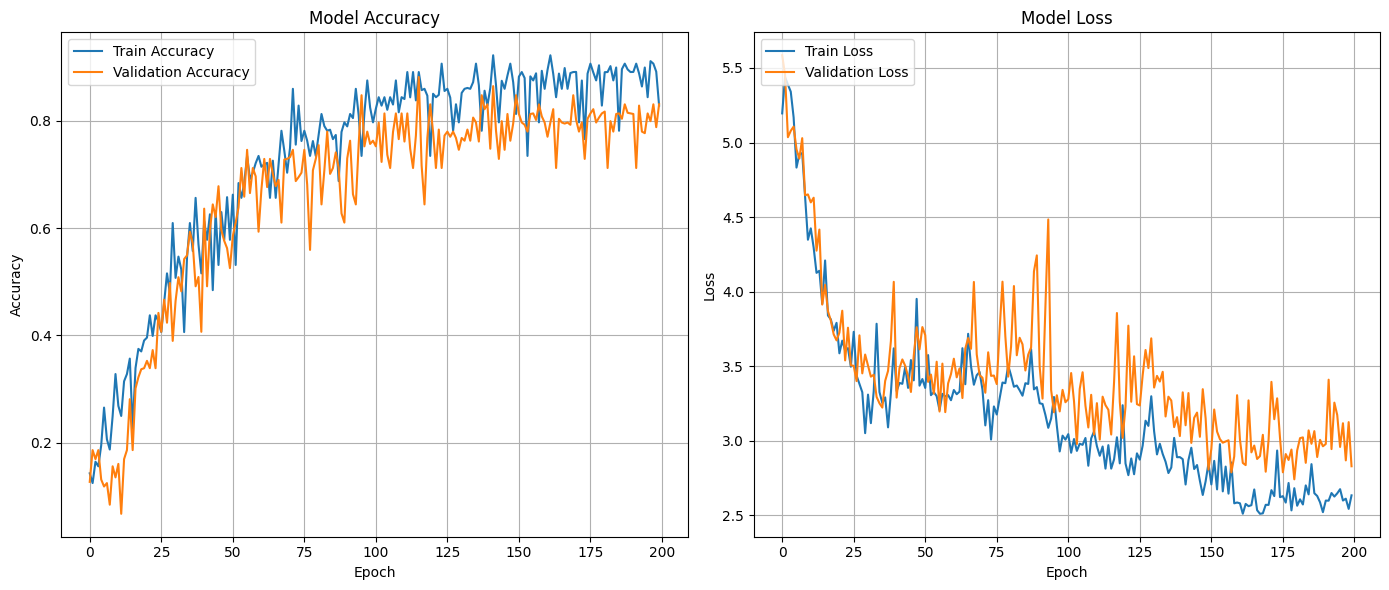

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# **6. Testing Results and Evaluation Metrics:**

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.8106 - loss: 3.0801
Test Accuracy: 79.50%
Test Loss: 3.1868
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step
              precision    recall  f1-score   support

     hyundai       0.09      0.08      0.09        50
       lexus       0.18      0.20      0.19        50
       mazda       0.07      0.06      0.07        50
    mercedes       0.20      0.26      0.22        50
        opel       0.12      0.10      0.11        50
       skoda       0.14      0.14      0.14        50
      toyota       0.11      0.08      0.09        50
  volkswagen       0.05      0.06      0.05        50

    accuracy                           0.12       400
   macro avg       0.12      0.12      0.12       400
weighted avg       0.12      0.12      0.12       400



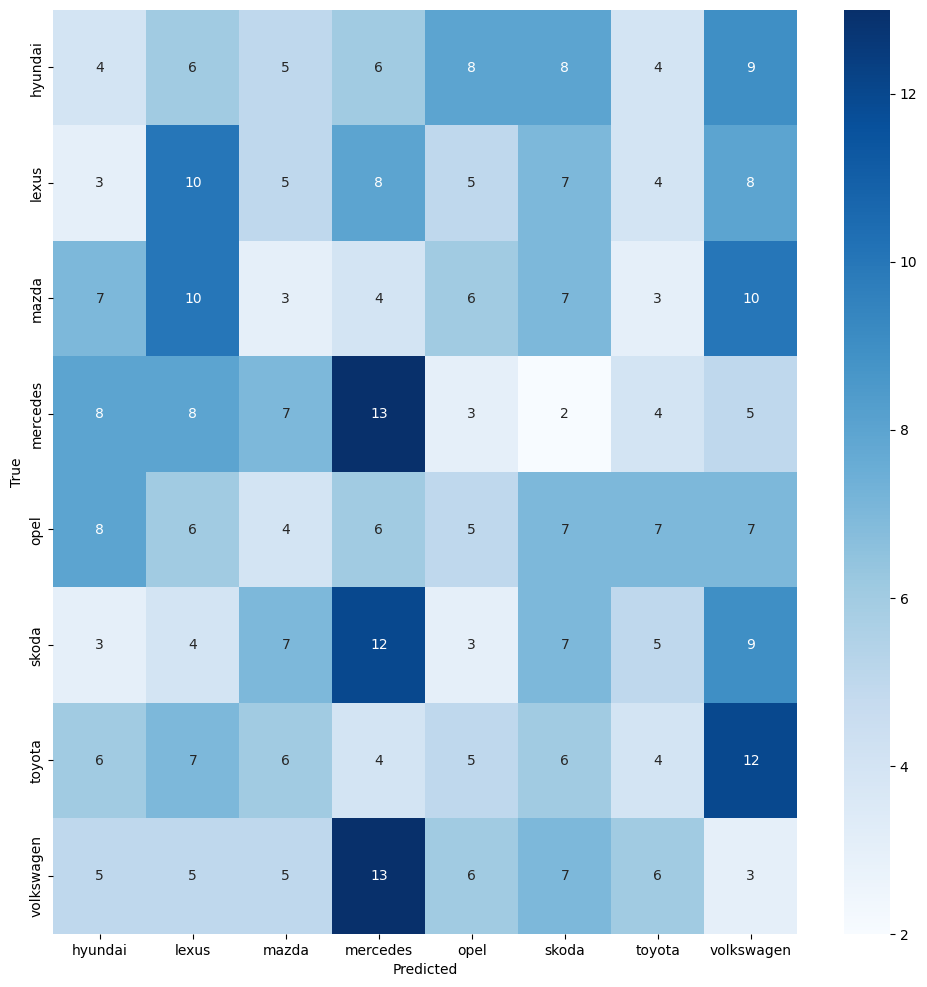

In [21]:
#Testing:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm = metrics.confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

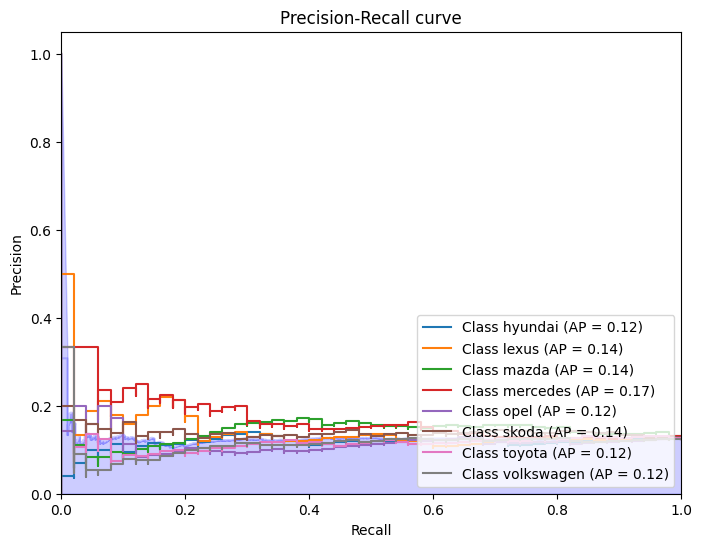

In [29]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(class_labels)):
    precision[i], recall[i], _ = metrics.precision_recall_curve((true_classes == i).astype(int), predictions[:, i])
    average_precision[i] = metrics.average_precision_score((true_classes == i).astype(int), predictions[:, i])

precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(
    utils.to_categorical(true_classes).ravel(), predictions.ravel()
)
average_precision["micro"] = metrics.average_precision_score(utils.to_categorical(true_classes), predictions, average="micro")
plt.figure(figsize=(8, 6))
plt.step(recall["micro"], precision["micro"], color="b", alpha=0.2, where="post")
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color="b")

for i in range(len(class_labels)):
    plt.step(
        recall[i], precision[i], where="post", label=f"Class {class_labels[i]} (AP = {average_precision[i]:0.2f})"
    )
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.legend(loc="lower right")
plt.show()

# **7. Testing The CNN on Samples from Test Dataset:**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


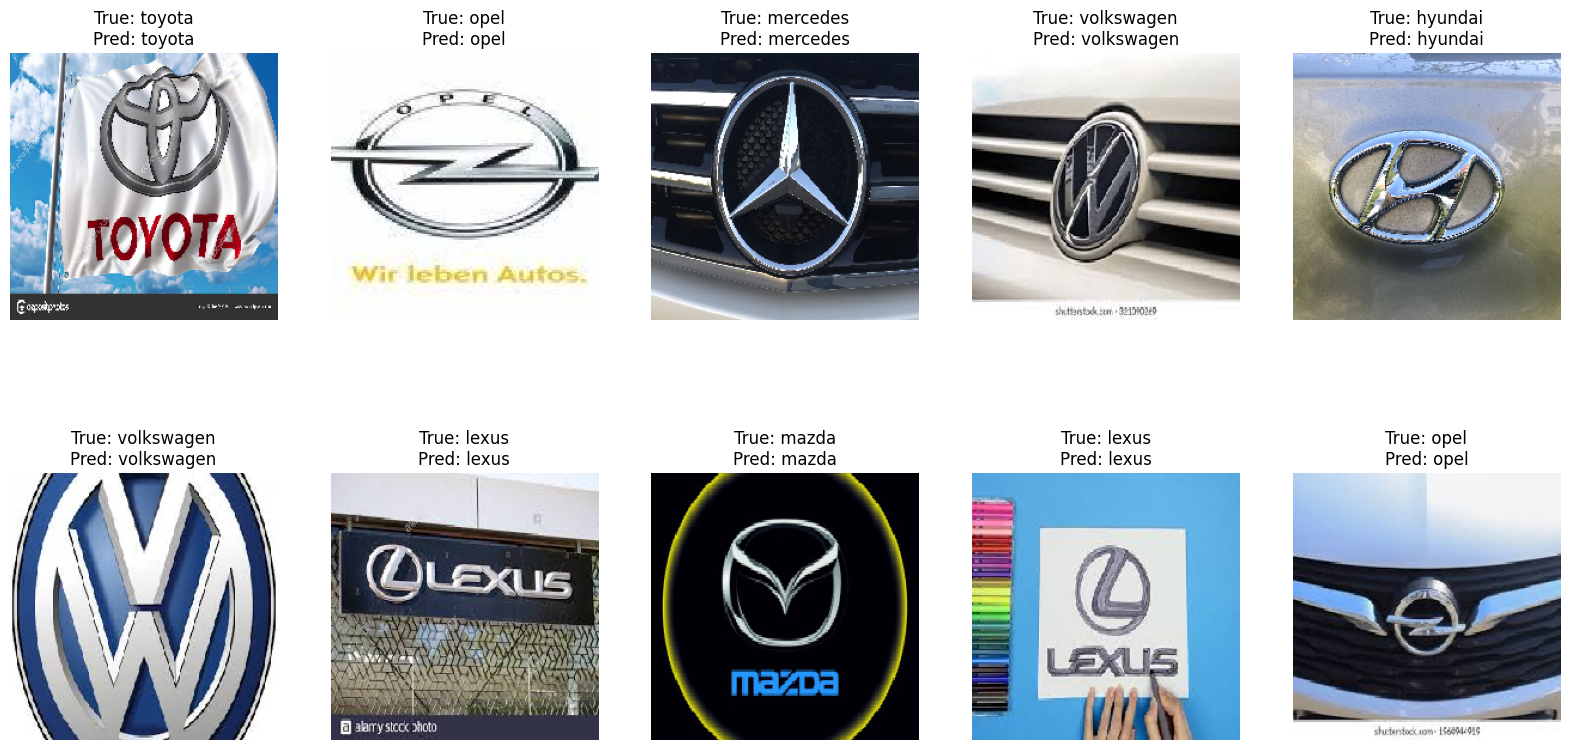

In [14]:
def plot_predictions(generator, model, num_images=10):
    x, y = next(generator)
    predictions = model.predict(x)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(x[i])
        plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')
    plt.show()

plot_predictions(test_generator, model)

# **8. Testing The CNN on 4 Random Samples Outside all Datasets (Training, Validation, Testing):**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


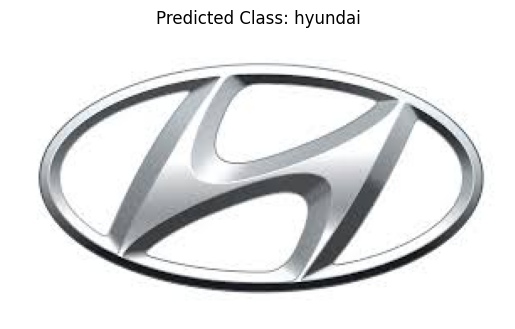

Predicted Class: hyundai
Predicted Probabilities: [[9.9971789e-01 2.2643255e-06 3.3925113e-07 1.7335078e-04 2.2804565e-07
  1.0254183e-06 1.9349480e-05 8.5555417e-05]]


In [17]:
# Testing On Individual Car Logos Outside dataset: Hyundai
image_path = "/kaggle/input/testing-carlogos/hyundaiTest.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))  
image = image / 255.0

image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: ' + predicted_label)
plt.axis('off')
plt.show()

print("Predicted Class:", predicted_label)
print("Predicted Probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


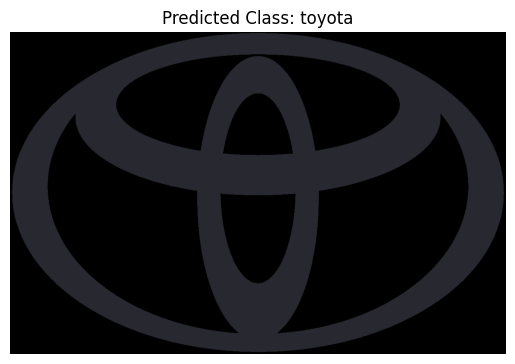

Predicted Class: toyota
Predicted Probabilities: [[0.01800679 0.0713041  0.19828539 0.03229155 0.09997964 0.02403894
  0.44482094 0.11127265]]


In [18]:
# Testing On Individual Car Logos Outside dataset: Toyota
image_path = "/kaggle/input/testing-carlogos/toyotaTest.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))  
image = image / 255.0

image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: ' + predicted_label)
plt.axis('off')
plt.show()

print("Predicted Class:", predicted_label)
print("Predicted Probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


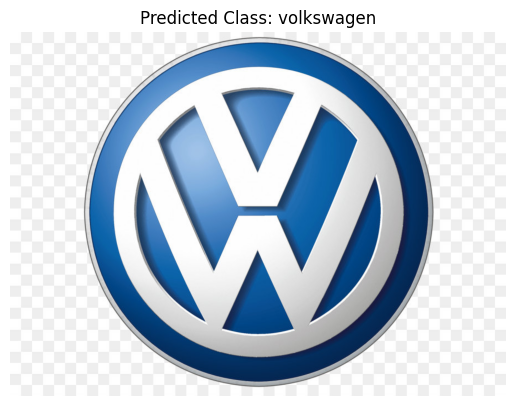

Predicted Class: volkswagen
Predicted Probabilities: [[1.0938814e-09 3.3851808e-09 5.3520275e-14 8.6087963e-11 3.2866522e-14
  7.0385076e-09 3.2735221e-09 1.0000000e+00]]


In [19]:
# Testing On Individual Car Logos Outside dataset: Volkswagen
image_path = "/kaggle/input/testing-carlogos/volkswagenTest.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))  
image = image / 255.0

image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: ' + predicted_label)
plt.axis('off')
plt.show()

print("Predicted Class:", predicted_label)
print("Predicted Probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


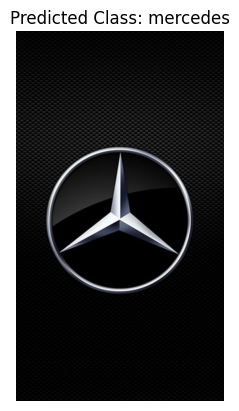

Predicted Class: mercedes
Predicted Probabilities: [[1.45614074e-04 1.21784515e-05 3.32247728e-05 9.94775295e-01
  4.82783234e-03 5.93138111e-06 1.95581670e-04 4.31402805e-06]]


In [20]:
# Testing On Individual Car Logos Outside dataset: Mercedes
image_path = "/kaggle/input/testing-carlogos/mercedesTest.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))  
image = image / 255.0

image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
predicted_class = np.argmax(predictions)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: ' + predicted_label)
plt.axis('off')
plt.show()

print("Predicted Class:", predicted_label)
print("Predicted Probabilities:", predictions)